# Task 4: Proxy Target Variable Engineering
## Creating High-Risk Customer Labels using RFM Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
PROCESSED_PATH = "../data/processed/model_features.csv"
OUTPUT_PATH = "../data/processed/model_features_with_target.csv"

## 1. Load and Verify Data

In [2]:
# Load processed data
processed_df = pd.read_csv(PROCESSED_PATH)

# Check for customer ID column (handling both possible column names)
customer_id_col = None
for col in ['id__customerid', 'customerid']:
    if col in processed_df.columns:
        customer_id_col = col
        break

if not customer_id_col:
    raise ValueError("No customer ID column found - check your Task 3 processing")

print(f"Using '{customer_id_col}' as customer identifier")

# Standardize column name for easier processing
processed_df = processed_df.rename(columns={customer_id_col: 'customerid'})

Using 'id__customerid' as customer identifier


## 2. Calculate RFM Metrics per Customer
Using the pre-calculated RFM features from Task 3

RFM Metrics Summary:


,num__recency,num__frequency,num__monetary
count,3742.000000,3742.000000,3742.000000
mean,0.806854,-0.418174,0.103614
std,1.382280,0.110319,1.959285
min,-0.796029,-0.446132,-0.115257
25%,-0.490241,-0.444993,-0.102262
50%,0.478089,-0.439303,-0.069625
75%,1.956067,-0.424507,-0.032815
max,3.841763,4.208861,100.529897


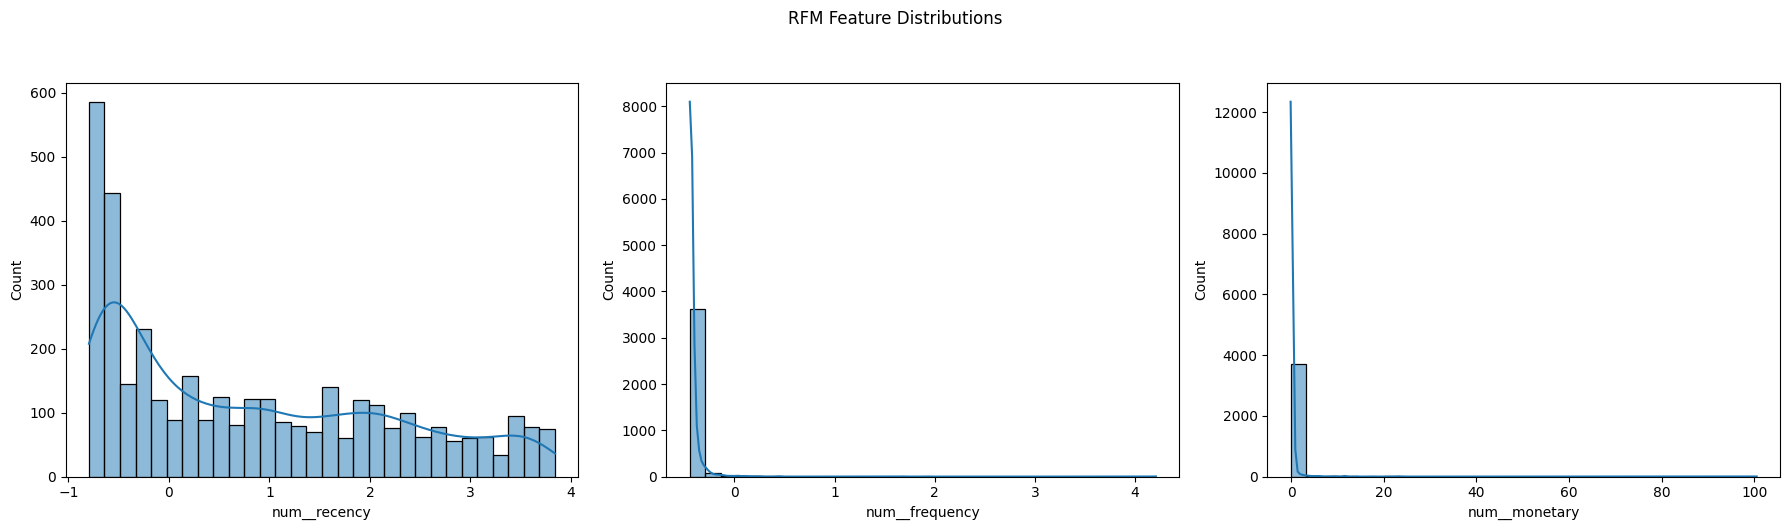

In [3]:
# Get first record per customer (since RFM features are constant per customer)
rfm_metrics = processed_df.groupby('customerid').agg({
    'num__recency': 'first',
    'num__frequency': 'first', 
    'num__monetary': 'first'
}).reset_index()

print("RFM Metrics Summary:")
display(rfm_metrics.describe())

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm_metrics['num__recency'], bins=30, kde=True, ax=axes[0])
sns.histplot(rfm_metrics['num__frequency'], bins=30, kde=True, ax=axes[1])
sns.histplot(rfm_metrics['num__monetary'], bins=30, kde=True, ax=axes[2])
plt.suptitle('RFM Feature Distributions', y=1.05)
plt.tight_layout()
plt.show()

## 3. Cluster Customers Using RFM Features

In [4]:
# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_metrics[['num__recency', 'num__frequency', 'num__monetary']])

# Cluster customers
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_metrics['cluster'] = kmeans.fit_predict(rfm_scaled)

# Show cluster distribution
print("\nCustomer Distribution by Cluster:")
print(rfm_metrics['cluster'].value_counts())


Customer Distribution by Cluster:
cluster
1    2293
0    1448
2       1
Name: count, dtype: int64


## 4. Identify High-Risk Cluster


Cluster Statistics:


,num__recency,num__frequency,num__monetary
cluster,,,
0,2.337634,-0.438406,0.121312
1,-0.159181,-0.405388,0.048641
2,-0.643135,-0.439303,100.529897


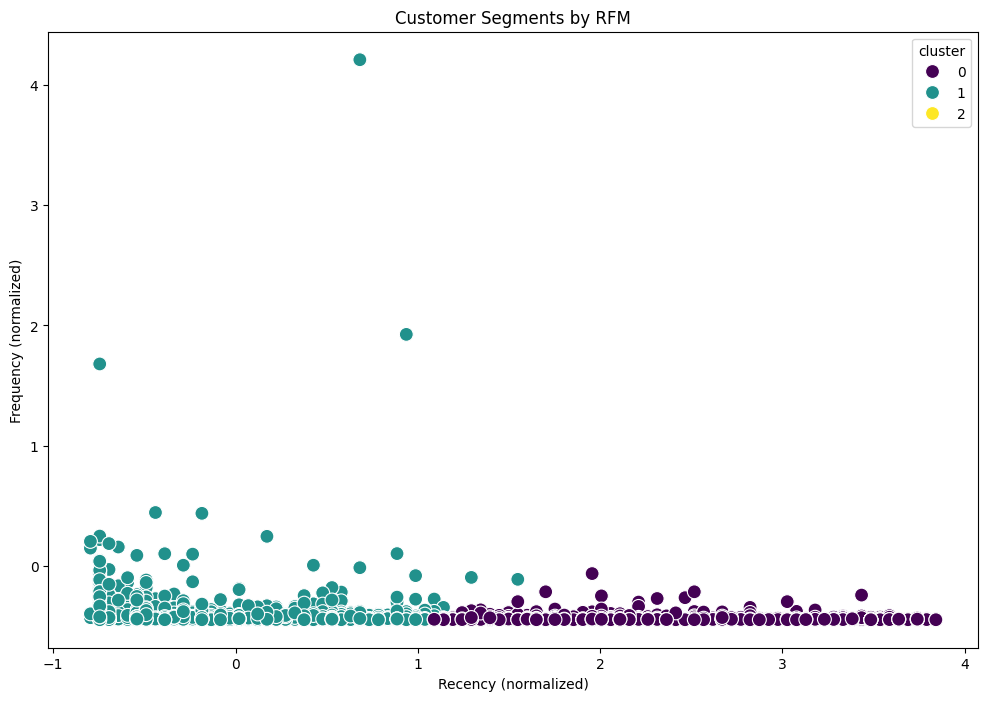

In [5]:
# Analyze clusters
cluster_stats = rfm_metrics.groupby('cluster').agg({
    'num__recency': 'mean',
    'num__frequency': 'mean',
    'num__monetary': 'mean'
}).sort_values(
    ['num__recency', 'num__frequency', 'num__monetary'],
    ascending=[False, True, True]  # High recency, low frequency/monetary = highest risk
)

high_risk_cluster = cluster_stats.index[0]
rfm_metrics['is_high_risk'] = (rfm_metrics['cluster'] == high_risk_cluster).astype(int)

print("\nCluster Statistics:")
display(cluster_stats)

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm_metrics,
    x='num__recency',
    y='num__frequency',
    hue='cluster',
    palette='viridis',
    s=100
)
plt.title('Customer Segments by RFM')
plt.xlabel('Recency (normalized)')
plt.ylabel('Frequency (normalized)')
plt.show()

## 5. Merge Labels with Processed Data

In [6]:
# Merge risk labels back
final_df = processed_df.merge(
    rfm_metrics[['customerid', 'is_high_risk']],
    on='customerid',
    how='left'
)

# Validate merge
print("\nMerge Validation:")
print(f"Original records: {len(processed_df)}")
print(f"Merged records: {len(final_df)}")
print(f"Missing target values: {final_df['is_high_risk'].isna().sum()}")

# Show target distribution
print("\nTarget Variable Distribution:")
print(final_df['is_high_risk'].value_counts(normalize=True))


Merge Validation:
Original records: 95662
Merged records: 95662
Missing target values: 0

Target Variable Distribution:
is_high_risk
0    0.882116
1    0.117884
Name: proportion, dtype: float64


## 6. Save Results

In [7]:
final_df.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved final data with target to: {OUTPUT_PATH}")


Saved final data with target to: ../data/processed/model_features_with_target.csv


## 7. Business Interpretation

In [8]:
print("\nBusiness Interpretation:")
print(f"Identified High Risk Cluster: {high_risk_cluster}")
print("Characteristics:")
print(f"- Recency (normalized): {cluster_stats.loc[high_risk_cluster, 'num__recency']:.2f}")
print(f"- Frequency (normalized): {cluster_stats.loc[high_risk_cluster, 'num__frequency']:.2f}")
print(f"- Monetary (normalized): {cluster_stats.loc[high_risk_cluster, 'num__monetary']:.2f}")

# Sample high-risk customers
high_risk_customers = rfm_metrics[rfm_metrics['is_high_risk'] == 1]['customerid'].head(5).tolist()
print(f"\nSample High-Risk Customer IDs: {high_risk_customers}")


Business Interpretation:
Identified High Risk Cluster: 0
Characteristics:
- Recency (normalized): 2.34
- Frequency (normalized): -0.44
- Monetary (normalized): 0.12

Sample High-Risk Customer IDs: ['CustomerId_1', 'CustomerId_10', 'CustomerId_1001', 'CustomerId_1004', 'CustomerId_1005']
